In [13]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split#, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from pandas_profiling import ProfileReport
from category_encoders import OneHotEncoder
import ipywidgets

# how to become a superhost:
# https://www.airbnb.com/help/article/829/how-do-i-become-a-       

In [14]:
filepath = 'Data/listings.csv.gz'

def wrangle(filepath):
    air = pd.read_csv(filepath, index_col='id')

    # Dropping columns with too many null values
    drop_cols_null = ['neighbourhood_group_cleansed', 'bathrooms',
                     'calendar_updated']
    # air.isnull().sum()
    air.drop(columns=drop_cols_null, inplace=True)
    
    # Dropping columns that seem irrelevant URL links
    drop_cols = ['listing_url', 'scrape_id', 'picture_url', 'description',
                 'neighborhood_overview', 'host_url', 'host_location', 'name',
                 'host_name', 'host_about', 'host_thumbnail_url',
                 'host_picture_url', 'host_neighbourhood', 'neighbourhood',
                 'host_total_listings_count',
                 'last_scraped']

    # Seem irrelevant/ noise for our data
    drop_cols2 = ['minimum_nights', 'maximum_nights',
                  'minimum_minimum_nights', 'maximum_minimum_nights',
                   'minimum_maximum_nights', 'maximum_maximum_nights',
                   'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
                   'availability_30', 'availability_60', 'availability_90',
                   'availability_365', 'calendar_last_scraped',
                   'calculated_host_listings_count',
                   'calculated_host_listings_count_entire_homes',
                   'calculated_host_listings_count_private_rooms',
                   'calculated_host_listings_count_shared_rooms',
                   'review_scores_accuracy',
                   'review_scores_cleanliness', 'review_scores_checkin',
                   'review_scores_communication', 'review_scores_location',
                   'review_scores_value', 'license', 'number_of_reviews_ltm',
                   'number_of_reviews_l30d', 'first_review', 'last_review', 'host_acceptance_rate',
                   'reviews_per_month',
                   'host_response_time', 'host_response_rate', 'host_since']
    air.drop(columns=drop_cols, inplace=True)
    air.drop(columns=drop_cols2, inplace=True)

    # Change the columns t (true) and f (false) to 0 and 1's
    ### note, change type
    
    # Dropping the host_id

    air.loc[air['host_identity_verified'] == "t", 'host_identity_verified'] = 1
    air.loc[air['host_identity_verified'] == "f", 'host_identity_verified'] = 0

    air.loc[air['host_has_profile_pic'] == "t", 'host_has_profile_pic'] = 1
    air.loc[air['host_has_profile_pic'] == "f", 'host_has_profile_pic'] = 0

    air.loc[air['instant_bookable'] == "t", 'instant_bookable'] = 1
    air.loc[air['instant_bookable'] == "f", 'instant_bookable'] = 0

    air['super_host'] = 1
    air.loc[air['host_is_superhost'] == 'f', 'super_host'] = 0
    air.drop(columns='host_is_superhost', inplace=True)

    # cleaning the price column to be integers
    air['price'] = air['price'].str.replace(',', '').str.strip('$').astype(float)

    #if we have time we can review this items:
    cols_stretch_goal = ['host_verifications', 'amenities', 'property_type']
    air.drop(columns=cols_stretch_goal, inplace=True)

    air.head(20)
    # Let's rename the columns
#     air.columns = ['host_id', 'listing_count', 'profile_pic', 'id_verified',
#                   'ward', 'lat', 'long', 'room_type', 'guest_count', 'bath',
#                   'bedroom', 'beds', 'price', 'review_count', 'review_score',
#                   'ins_book', 'super_host']
    
    return air

In [15]:
air = wrangle(filepath)
air.head(5)

,host_id,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,price,number_of_reviews,review_scores_rating,instant_bookable,super_host
id,,,,,,,,,,,,,,,,,
197677,964081,1.0,1,0,Sumida Ku,35.71721,139.82596,Entire home/apt,4,1 bath,1.0,2.0,11000.0,165,95.0,0,0
776070,801494,1.0,1,1,Kita Ku,35.73844,139.76917,Private room,2,1 shared bath,1.0,1.0,7677.0,228,99.0,1,1
899003,4799233,2.0,1,1,Shinjuku Ku,35.71019,139.69755,Entire home/apt,3,1 bath,1.0,4.0,5200.0,93,90.0,0,0
1016831,5596383,1.0,1,1,Setagaya Ku,35.65800,139.67134,Private room,2,1 shared bath,1.0,1.0,4000.0,211,99.0,0,0
1033276,5686404,NaN,NaN,NaN,Adachi Ku,35.74437,139.79739,Private room,2,1 shared bath,1.0,0.0,30000.0,72,91.0,0,1


In [16]:
# profile = ProfileReport(air)

In [17]:
# profile

In [19]:
# wards = air.ward.unique()
# print(wards)

In [20]:
air.columns

Index(['host_id', 'host_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms',
       'beds', 'price', 'number_of_reviews', 'review_scores_rating',
       'instant_bookable', 'super_host'],
      dtype='object')

In [21]:
# air.property_type.unique()

In [22]:
air.room_type.unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [23]:
# ver_list = []
# for person in verifications:
#     new = person.split(",")
#     for item in new:
#         verification_item =item.replace("'", '').strip("[").strip("]").strip(' ')
#         if verification_item not in ver_list:
#             print(verification_item)
#             ver_list.append(verification_item)
# len(ver_list)

In [24]:
# air.number_of_reviews.describe()

In [25]:
air.instant_bookable.describe()

count     11197
unique        2
top           1
freq       8301
Name: instant_bookable, dtype: int64

In [26]:
# for future reference: data for the station's locations
# https://ckan-tokyochallenge.odpt.org/en/dataset?tags=列車ロケーション情報-train_location_information


In [27]:
target='price'
X = air.drop(columns=target)
y = air[target]

# Let's split into a test and
X_train, X_t, y_train, y_t = train_test_split(X,y, test_size=.2, random_state=7)

# Let's split our test data into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_t,y_t, test_size=.2, random_state=7)

print('Training:', len(X_train))
print('Validation:', len(X_val))
print('Test:', len(X_test))

Training: 8957
Validation: 1792
Test: 448


In [28]:
# Random forest regression

model_rf = make_pipeline(OneHotEncoder(),
                         SimpleImputer(),
                         RandomForestRegressor(random_state=70))
model_rf.fit(X_train,y_train);


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [29]:
# Mean Absolute Error Accuracy Score
# Training
print('Random Forest Regressor')

y_pred = len(y_train) *[y_train.mean()]
baseline_mae = mean_absolute_error(y_train,y_pred)
print('Baseline MAE: ', baseline_mae)

training_acc = mean_absolute_error(y_train,model_rf.predict(X_train))
print('MAE Train: ', training_acc)

# Validation
val_acc = mean_absolute_error(y_val,model_rf.predict(X_val))
print('MAE Validation: ',val_acc)

# R squared
print('Rsquared Validation:', r2_score(y_val, model_rf.predict(X_val)))

Random Forest Regressor
Baseline MAE:  9628.7062014588
MAE Train:  2564.681873041126
MAE Validation:  6042.410634090224
Rsquared Validation: 0.48636046735139715


In [30]:
X_val

,host_id,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,number_of_reviews,review_scores_rating,instant_bookable,super_host
id,,,,,,,,,,,,,,,,
9914704,49237439,8.0,1,1,Edogawa Ku,35.74012,139.89638,Private room,4,2.5 shared baths,1.0,2.0,17,78.0,1,0
42184333,25865449,19.0,1,1,Shinjuku Ku,35.70124,139.70410,Private room,3,1 private bath,1.0,3.0,0,NaN,1,0
44308809,49124251,39.0,1,1,Taito Ku,35.71737,139.79377,Private room,2,1.5 baths,1.0,0.0,3,100.0,0,1
38545760,293219732,8.0,1,1,Koto Ku,35.69992,139.83095,Entire home/apt,3,1 bath,1.0,2.0,15,91.0,1,0
37880175,286925159,1.0,1,1,Meguro Ku,35.63928,139.68968,Private room,3,2 shared baths,1.0,2.0,3,100.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45426600,241372894,1.0,1,1,Shinjuku Ku,35.70456,139.69843,Entire home/apt,5,1 bath,2.0,2.0,3,80.0,1,0
27530652,207664421,2.0,1,1,Kita Ku,35.77292,139.72235,Entire home/apt,7,1 bath,1.0,4.0,101,92.0,1,0
34070227,229388614,7.0,1,1,Edogawa Ku,35.71026,139.84373,Entire home/apt,10,1 bath,1.0,4.0,26,94.0,1,0


In [31]:
# dir(model_rf.named_steps['randomforestregressor'])

AttributeError: module 'matplotlib' has no attribute 'xlabel'

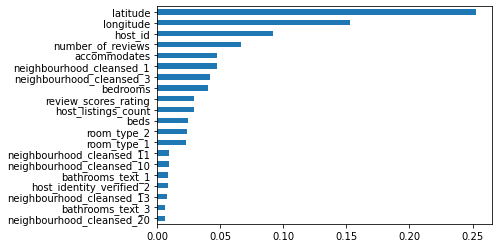

In [32]:
# Create bar chart
# Add coefficients from Model_r's named steps
coefficients = model_rf.named_steps['randomforestregressor'].feature_importances_

# Add feature names from Model_r's named steps
features = model_rf.named_steps['onehotencoder'].get_feature_names()

# Combine the two values into a single object, sorting based on the absolute value
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)

# Create the bar chart and limit it to the top 10 features
feat_imp.tail(20).plot(kind='barh')
# Add labels to the chart
plt.xlabel('Coefficient [$]')
plt.ylabel('Feature')
plt.title('Top 10 Coefficients for Ridge Regression \nand Their Impact on Sale Price');

In [ ]:
df_feature_importances = pd.DataFrame(model.named_steps['randomorestregressor'].feature_importances_*100,columns=["Importance"],index=col_names)
df_feature_importances = df_feature_importances.sort_values("Importance", ascending=False)

In [ ]:
len(air)

In [ ]:
air.to_csv('clean_data.csv')

In [ ]:
air.columns

In [33]:
clean_data = pd.read_csv('clean_data.csv')
clean_data.columns

Index(['id', 'host_id', 'host_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms',
       'beds', 'price', 'number_of_reviews', 'review_scores_rating',
       'instant_bookable', 'super_host'],
      dtype='object')